## 📦 **Import Libraries**

In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.3 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

## 🗃️ **Data Preparation**

In [ ]:
dir = '/content/drive/Shareddrives/Capstone Project/Product-based/ml-stuff/data/'

projects = pd.read_csv(dir + 'projects_preprocessed_minimum.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [ ]:
projects.head()

,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,penulis yang tinggal di apartemen jakarta menu...,7.0,['Writing'],250000.0
1,1,membuat artikel di media online pekerjaan memb...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,editing 12 shortt video untuk konten tiktok hi...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,cari akun canva creator element atau template ...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,cari jasa upload aplikasi ke app store sedang ...,7.0,['iPhone/iOS'],150000.0


In [ ]:
projects = projects.drop('Unnamed: 0', axis=1)

In [ ]:
projects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39227 entries, 0 to 39226
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text_clean  39224 non-null  object 
 1   finishDays  39227 non-null  float64
 2   tags_token  39227 non-null  object 
 3   budget      39227 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

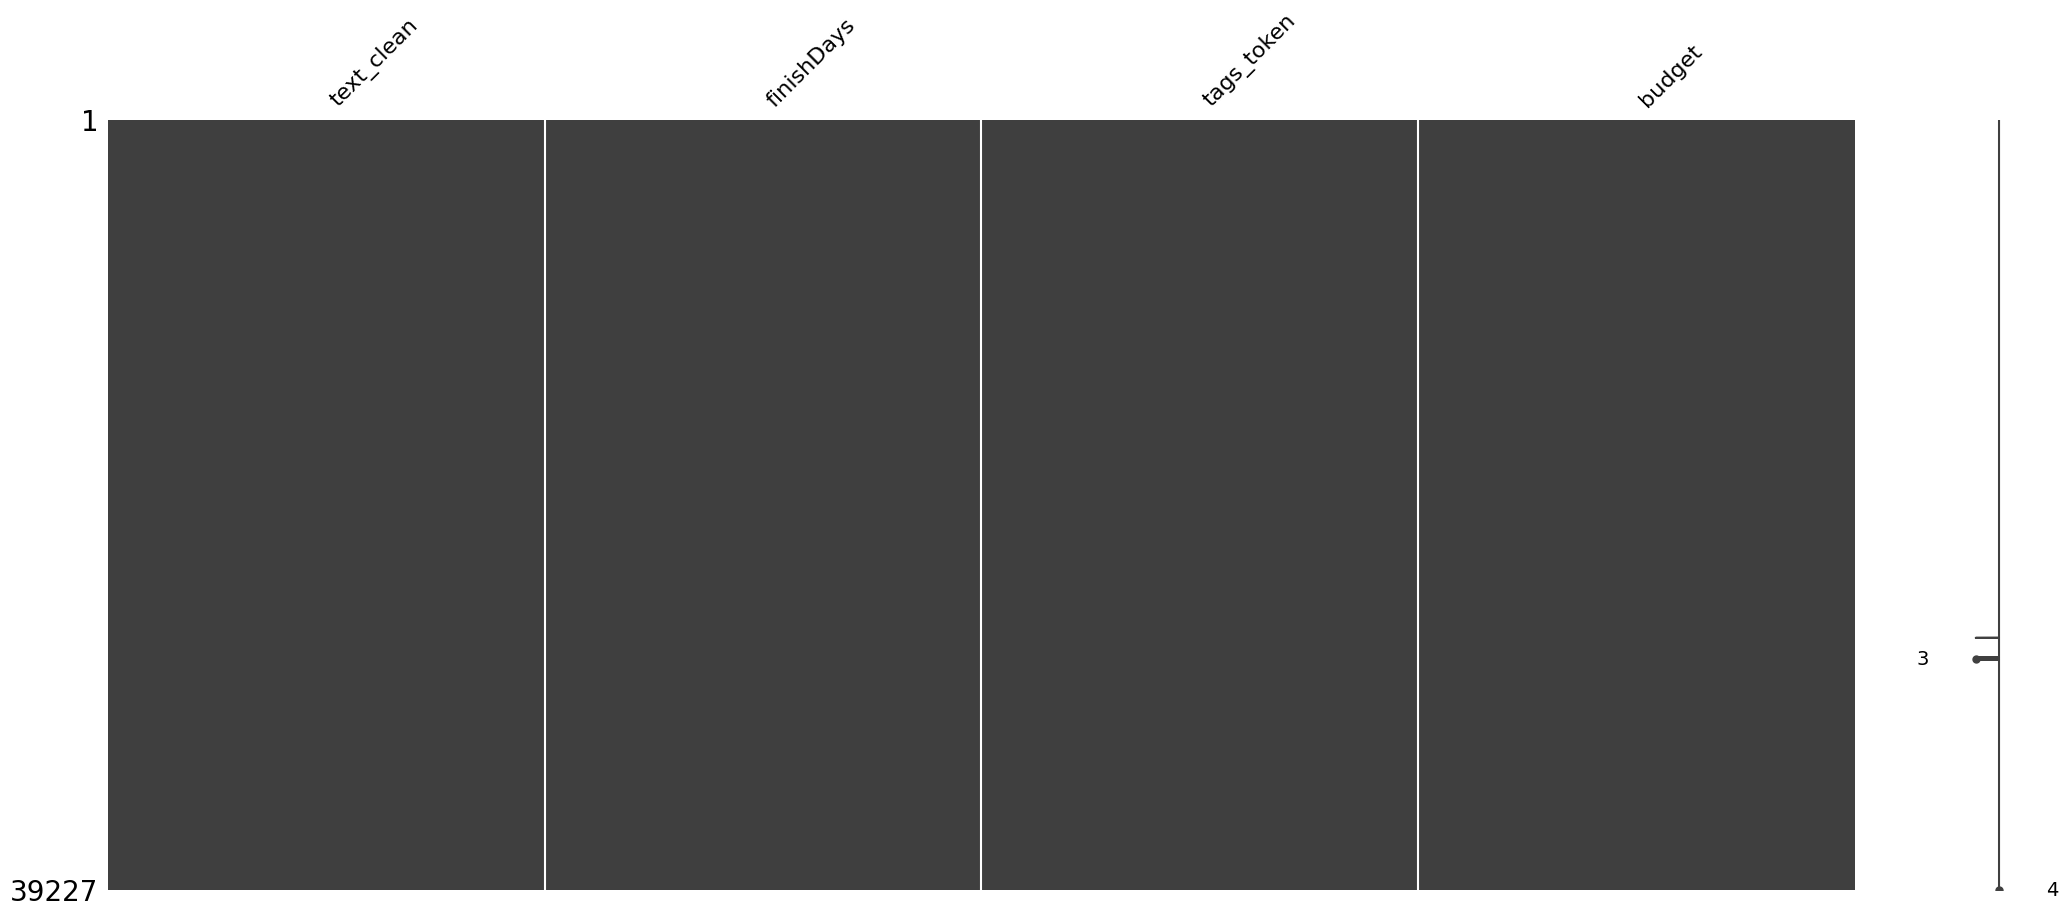

In [ ]:
msno.matrix(projects)
plt.show()

In [ ]:
round(projects.isna().mean().sort_values(ascending = False), 4)

text_clean    0.0001
finishDays    0.0000
tags_token    0.0000
budget        0.0000
dtype: float64

### **Target Overview**

##### `budget`

In [ ]:
df = projects

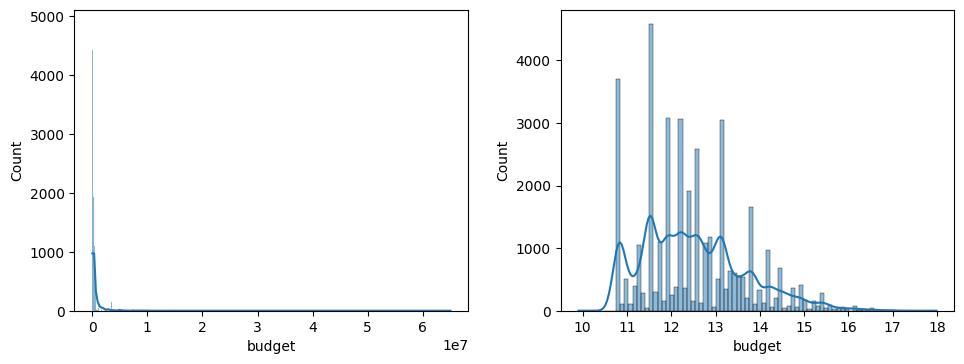

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.histplot(df['budget'], kde = True, ax = axes[0])
sns.histplot(np.log(df['budget']), kde = True, ax = axes[1])

plt.tight_layout(pad = 2)
plt.show()

## Modeling

In [ ]:
df.rename(columns = {'text_clean':'text'}, inplace = True)
df['text'] = df['text'].astype(str)

In [ ]:
df = df[df['budget'] < 25000000]

In [ ]:
df['budget_tags'] = np.select(
    [df['budget'].between(20000, 50000),
     df['budget'].between(50000, 100000),
     df['budget'].between(100000, 150000),
     df['budget'].between(150000, 200000),
     df['budget'].between(200000, 250000),
     df['budget'].between(250000, 300000),
     df['budget'].between(300000, 350000),
     df['budget'].between(350000, 450000),
     df['budget'].between(450000, 500000),
     df['budget'].between(500000, 600000),
     df['budget'].between(600000, 700000),
     df['budget'].between(700000, 800000),
     df['budget'].between(800000, 900000),
     df['budget'].between(900000, 1000000),
     df['budget'].between(1000000, 1250000),
     df['budget'].between(1250000, 1500000),
     df['budget'].between(1500000, 1750000),
     df['budget'].between(1750000, 2000000),
     df['budget'].between(2000000, 2500000),
     df['budget'].between(2500000, 3000000),
     df['budget'].between(3000000, 4000000),
     df['budget'].between(4000000, 5000000),
     df['budget'].between(5000000, 6000000),
     df['budget'].between(6000000, 7000000),
     df['budget'].between(7000000, 8000000),
     df['budget'].between(8000000, 9000000),
     df['budget'].between(9000000, 10000000),
     df['budget'].between(10000000, 12500000),
     df['budget'].between(12500000, 15000000),
     df['budget'].between(15000000, 17500000),
     df['budget'].between(17500000, 20000000),
     df['budget'].between(20000000, 25000000)],
    ['20 - 50 Ribu', '50 - 100 Ribu', '100 - 150 Ribu', '150 - 200 Ribu','200 - 250 Ribu',
     '250 - 300 Ribu', '300 - 350 Ribu', '350 - 450 Ribu','450 - 500 Ribu', '500 - 600 Ribu',
     '600 - 700 Ribu', '700 - 800 Ribu', '800 - 900 Ribu', 
     '900 Ribu -  1 Juta', '1 -  1.25 Juta', '1.25 -  1.5 Juta', '1.5 -  1.75 Juta', '1.75 -  2 Juta', 
     '2 -  2.5 Juta', '2.5 -  3 Juta', '3 -  4 Juta', '4 -  5 Juta', '5 -  6 Juta', '6 -  7 Juta',
     '7 -  8 Juta', '8 -  9 Juta', '9 -  10 Juta', '10 -  12.5 Juta', '12.5 -  15 Juta',
     '15 -  17.5 Juta', '17.5 -  20 Juta', '20 -  25 Juta'],
    np.nan
)

In [ ]:
df.head()

,text,finishDays,tags_token,budget,budget_tags
0,penulis yang tinggal di apartemen jakarta menu...,7.0,['Writing'],250000.0,200 - 250 Ribu
1,membuat artikel di media online pekerjaan memb...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0,300 - 350 Ribu
2,editing 12 shortt video untuk konten tiktok hi...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0,150 - 200 Ribu
3,cari akun canva creator element atau template ...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0,900 Ribu - 1 Juta
4,cari jasa upload aplikasi ke app store sedang ...,7.0,['iPhone/iOS'],150000.0,100 - 150 Ribu


In [ ]:
# Filtering the rare terms.
df_filtered = df.groupby("budget_tags").filter(lambda x: len(x) > 1)
df_filtered['budget_tags'] = df_filtered['budget_tags'].apply(lambda x: f"'{x}'")
df_filtered['budget_tags'] = df_filtered['budget_tags'].apply(lambda x: f'[{x}]')
df_filtered['budget_tags'] = list(df_filtered['budget_tags'].astype(str))

In [ ]:
df_filtered['budget_tags'].head()

0        ['200 - 250 Ribu']
1        ['300 - 350 Ribu']
2        ['150 - 200 Ribu']
3    ['900 Ribu -  1 Juta']
4        ['100 - 150 Ribu']
Name: budget_tags, dtype: object

In [ ]:
import ast 

df_filtered['budget_tags'] = [ast.literal_eval(i) for i in df_filtered['budget_tags']]
df_filtered['budget_tags'].values[:5]

array([list(['200 - 250 Ribu']), list(['300 - 350 Ribu']),
       list(['150 - 200 Ribu']), list(['900 Ribu -  1 Juta']),
       list(['100 - 150 Ribu'])], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["budget_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 35293
Number of rows in validation set: 1961
Number of rows in test set: 1961


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
terms = tf.ragged.constant(train_df["budget_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', '50 - 100 Ribu', '100 - 150 Ribu', '150 - 200 Ribu', '20 - 50 Ribu', '450 - 500 Ribu', '250 - 300 Ribu', '200 - 250 Ribu', '350 - 450 Ribu', '900 Ribu -  1 Juta', '300 - 350 Ribu', '1.25 -  1.5 Juta', '500 - 600 Ribu', '700 - 800 Ribu', '1.75 -  2 Juta', '600 - 700 Ribu', '2 -  2.5 Juta', '2.5 -  3 Juta', '1 -  1.25 Juta', '4 -  5 Juta', '3 -  4 Juta', '800 - 900 Ribu', '1.5 -  1.75 Juta', '5 -  6 Juta', '9 -  10 Juta', '6 -  7 Juta', '7 -  8 Juta', '12.5 -  15 Juta', '10 -  12.5 Juta', '8 -  9 Juta', '17.5 -  20 Juta', '15 -  17.5 Juta', '20 -  25 Juta']


In [ ]:
sample_label = train_df["budget_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['600 - 700 Ribu']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["budget_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Budget: {invert_multi_hot(label[0])}")
    print(" ")

Text: b'desain buku saya ingin desain buku universitas bahan sudah ada tinggal anda pikirkan desainnya saja total halaman 38 model buku ukuran panjang 21 cuma lebar 10 cuma bebas designnya yang penting elegant dan eye cathcing silakan sertakan desain buku yang pernah di buat'
Budget: ['150 - 200 Ribu']
 
Text: b'designer gambar kartun muslimah di cari real 100 bukan dari google jika hasil bajakan saya gugat butuh 10 pcs kartun muslimah untuk keperluan percetakan tas goodie bag 10 pcs gambar kartun muslimah'
Budget: ['100 - 150 Ribu']
 
Text: b'memindahkan dan merapikan naskah di masih word segera hello para workers selamat tahun baru 2020 mengawali tahun ini saya membutuhkan sagera editor untuk mengedit naskah saya di microsoft word sesuai materi yang akan saya berikan saya tunggu bid nya segera salam'
Budget: ['150 - 200 Ribu']
 
Text: b'perbaiki script html dear temans saya butuh bantuan untuk memperbaiki script saya coba copy ke index html style css dan js nya tapi saat run di local

In [ ]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

49065


In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

## Base Model

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(216, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [ ]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
276/276 [==============================] - 203s 726ms/step - loss: 0.1244 - binary_accuracy: 0.9663 - val_loss: 0.1044 - val_binary_accuracy: 0.9704
Epoch 2/20
276/276 [==============================] - 220s 798ms/step - loss: 0.0638 - binary_accuracy: 0.9771 - val_loss: 0.1220 - val_binary_accuracy: 0.9676
Epoch 3/20
276/276 [==============================] - 211s 765ms/step - loss: 0.0272 - binary_accuracy: 0.9913 - val_loss: 0.1601 - val_binary_accuracy: 0.9656
Epoch 4/20
267/276 [============================>.] - ETA: 7s - loss: 0.0166 - binary_accuracy: 0.9952

KeyboardInterrupt: ignored

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [ ]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

## Saving Model

In [ ]:
path = '/content/drive/Shareddrives/Capstone Project/Product-based/ml-stuff/model/'

In [ ]:
!mkdir -p saved_model
shallow_mlp_model.save(path + 'budget_label_model/my_model')

## Load Model

In [ ]:
budget_label_model = tf.keras.models.load_model(path + 'budget_label_model/my_model')

## Prediction

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, budget_label_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Budget: {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_1_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:1]
    print(f"Predicted Budget: ({', '.join([label for label in top_1_labels])})")
    print(" ")

4/4 [==============================] - 0s 6ms/step
Text: b'bikin perbaiki logo dan kartu nama dear all saya ada logo yang saya bikin sendiri ya tentunya kurang bagus orang rapi jadi butuh bantuan rekan2 untuk bikin ke format vektor dan png brandnya adalah untuk usaha agen pengiriman kecil2an khusus pengiriman luar negeri font untuk pedito merupakan font masque terlampir selain perbaiki logo di atas coba kasih pilihan warna versi lainnya oh ya bantu bikin kartu nama sekalian ya 2 face thank you maaf cuman project kecil2an'
Label(s): ['Adobe PhotoShop' 'Adobe Indesign']
Predicted Label(s): (Adobe Illustrator, Adobe PhotoShop, Logo Design, Adobe Indesign, Corel PhotoPaint)
 
Text: b'membuat program menggunakan java netbeans assalamualaykum karena kurangnya ilmu saya sedang mencari full freelance yang bisa membantu saya membuat aplikasi dan aplikasnya program menggunakan java netbeans bdget tidak besar'
Label(s): ['Java' 'NetBeans']
Predicted Label(s): (Java, NetBeans, Android studio, Java